In [1]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'roman-pandeia':
    path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

In [2]:
import numpy as np
import matplotlib
import time
import pickle
from pprint import pprint
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

from pyHalo.preset_models import CDM
from lenstronomy.LensModel.lens_model import LensModel

from package.plots import diagnostic_plot, plot, lens_plot
from package.helpers import pyhalo
from package.helpers.lens import Lens

plt.style.use(f'{repo_path}/package/mplstyle/science.mplstyle')

In [3]:
array_dir = os.path.join(repo_path, 'output', 'arrays', 'skypy_test')
data_dir = os.path.join('/data','bwedig', 'roman-population', 'data')
figure_dir = os.path.join(repo_path, 'figures')

In [4]:
csv_path = os.path.join(data_dir, 'dictparaggln_Area00000010.csv')
df = pd.read_csv(csv_path)

In [5]:
index = 3
row = df.iloc[index]

lens = Lens(z_lens=row['redslens'], 
            z_source=row['redssour'], 
            sigma_v=row['velodisp'], 
            lens_x=row['xposlens'], 
            lens_y=row['yposlens'], 
            source_x=row['xpossour'], 
            source_y=row['ypossour'], 
            mag_lens=row['magtlensF106'], 
            mag_source=row['magtsourF106'])

In [6]:
# add CDM subhalos
realizationCDM = CDM(lens.z_lens, lens.z_source, cone_opening_angle_arcsec=10, LOS_normalization=0.0)
print(f'Realization contains {len(realizationCDM.halos)} halos.')

Realization contains 25748 halos.


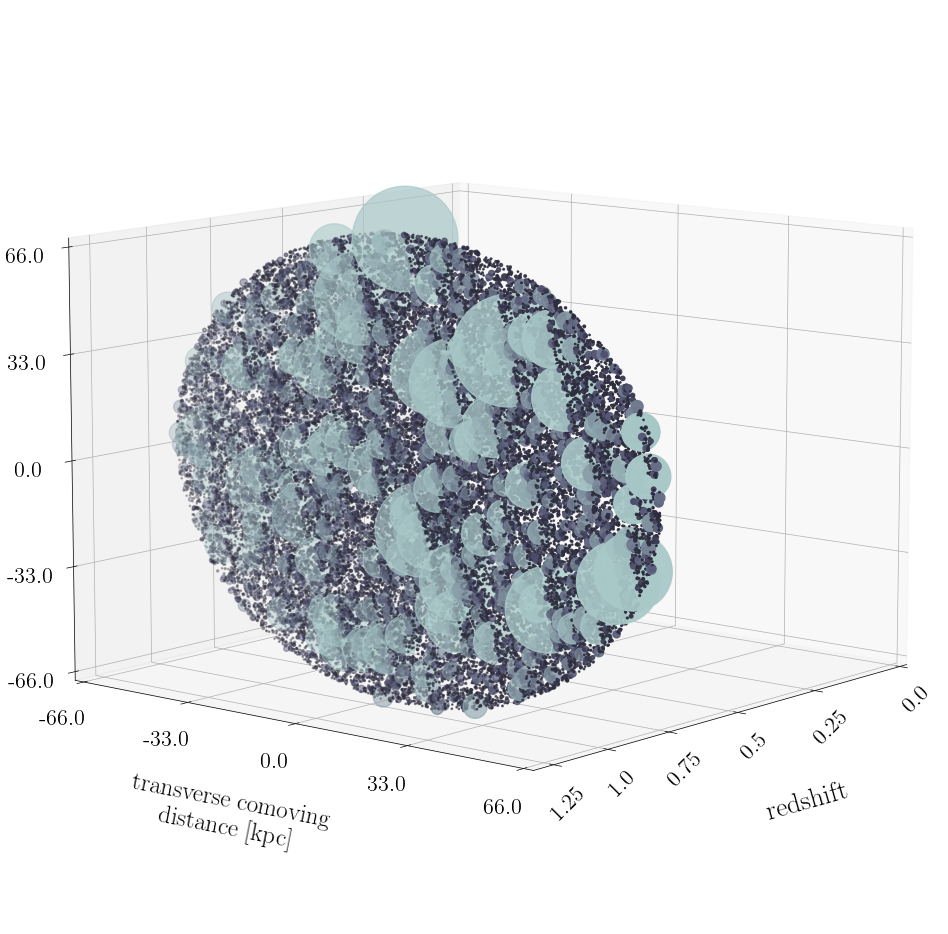

In [7]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(2)
fig.set_size_inches(14,12)
ax = plt.subplot(111, projection='3d')
realizationCDM.plot(ax, view_init_1=10., view_init_2=40.)
plt.savefig(os.path.join(figure_dir, 'subhalo_3d.png'))

In [8]:
halo_lens_model_list, halo_redshift_list, kwargs_halos, _ = realizationCDM.lensing_quantities()

# for some reason, halo_lens_model_list and kwargs_halos are lists, but halo_redshift_list is an ndarray
halo_redshift_list = halo_redshift_list.tolist()

lens.add_subhalos(halo_lens_model_list, halo_redshift_list, kwargs_halos)

In [9]:
lens_model_halos_only = LensModel(halo_lens_model_list, lens.z_lens, lens.z_source, halo_redshift_list, cosmo=lens.cosmo, multi_plane=True)

npix = 100 
_x = _y = np.linspace(-1.2, 1.2, npix)
xx, yy = np.meshgrid(_x, _y)
shape0 = xx.shape
kappa_subs = lens_model_halos_only.kappa(xx.ravel(), yy.ravel(), kwargs_halos).reshape(shape0)

(-0.5, 99.5, -0.5, 99.5)

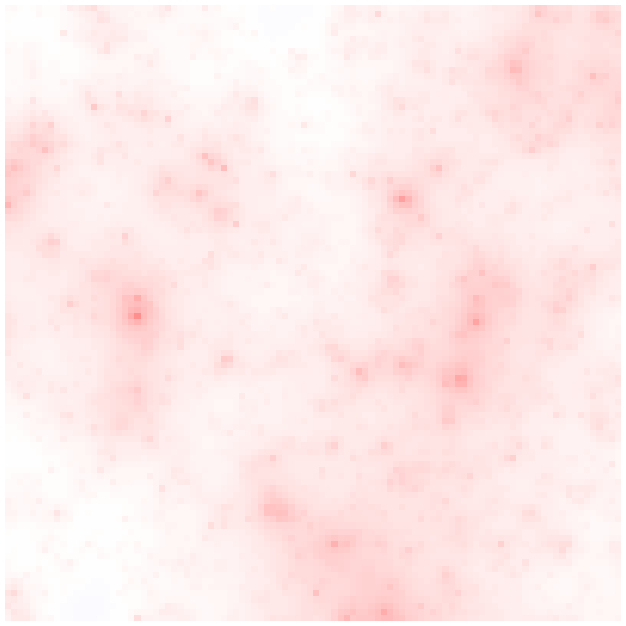

In [10]:
fig = plt.figure(1)
fig.set_size_inches(8,8)
plt.grid(False)
plt.imshow(kappa_subs, vmin=-0.1, vmax=0.1, cmap='bwr')
plt.axis('off')

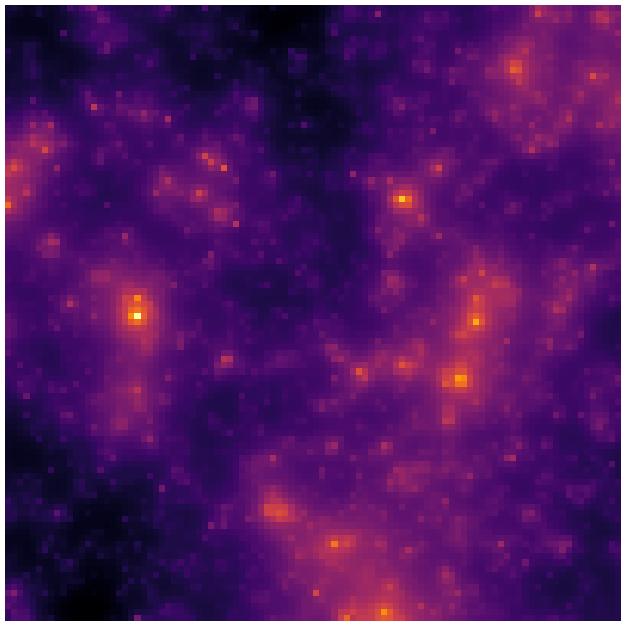

In [11]:
fig = plt.figure(1)
fig.set_size_inches(8,8)
plt.imshow(kappa_subs, cmap='inferno')  # vmin=-0.1, vmax=0.1
plt.axis('off')
plt.savefig(os.path.join(figure_dir, 'mass_projection.png'))

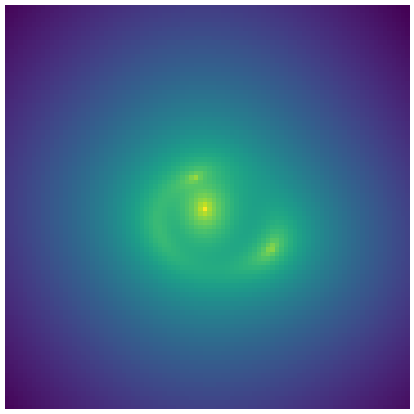

In [12]:
model = lens.get_array(num_pix=90, side=10.)

plt.imshow(np.log10(model), cmap='viridis')
plt.axis('off')

plt.savefig(os.path.join(figure_dir, 'sample_lenstronomy.png'))
plt.show()

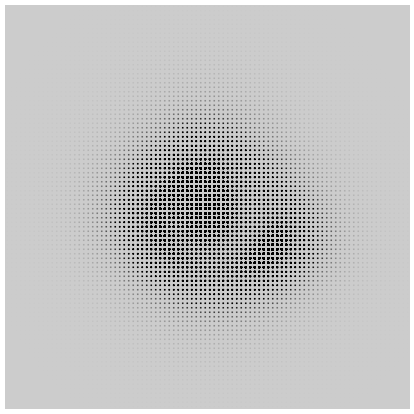

In [13]:
oversample_factor = 3
oversample_grid = np.zeros((model.shape[0] * oversample_factor, model.shape[1] * oversample_factor))
flattened_model = model.flatten()

k = 0

for i, row in enumerate(oversample_grid):
    for j, _ in enumerate(row):
        if not (i % oversample_factor) - 1 == 0:
            continue
        if (j % oversample_factor) - 1 == 0:
            oversample_grid[i][j] = flattened_model[k]
            k += 1

percentile = np.percentile(oversample_grid, 98)
vmin = -0.25 * percentile
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=percentile)

plt.imshow(oversample_grid, cmap='binary', norm=norm)
plt.axis('off')

plt.savefig(os.path.join(figure_dir, 'sample_phonions.png'))
plt.show()

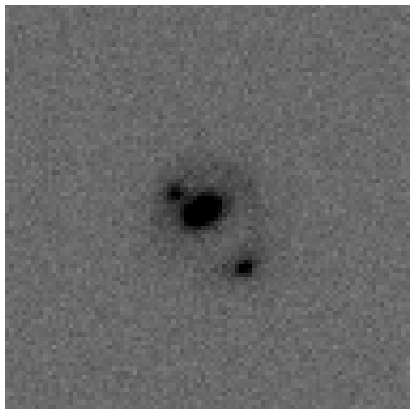

In [14]:
image_filepath = glob(array_dir + f'/skypy_output_*0{index}.npy')[0]
pandeia_image = np.load(image_filepath)

percentile = np.percentile(pandeia_image, 99.5)
vmin = -0.25 * percentile
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=percentile)

plt.imshow(pandeia_image, cmap='binary', norm=norm)
plt.axis('off')

plt.savefig(os.path.join(figure_dir, 'sample_pandeia.png'))
plt.show()

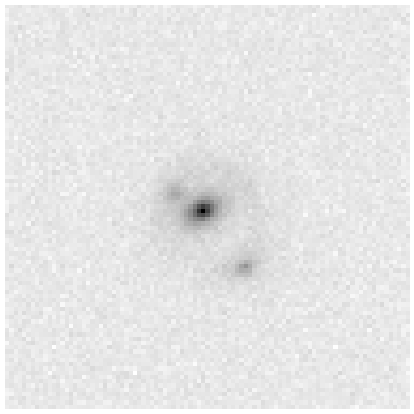

In [15]:
plt.imshow(np.log10(pandeia_image), cmap='binary')
plt.axis('off')

plt.savefig(os.path.join(figure_dir, 'sample_pandeia.png'))
plt.show()